# Best Reciprocal Sqrt ?

**Seemingly minor variations** in the way we approach computing **Reciprocal Sqrt** can perform as much as **3 to 4 orders of magnitude**faster or slower. 

Which one you choose depends on your need for **accuracy, speed, reability, maintainability**.

### See which one scores highest in your needs assetsment!

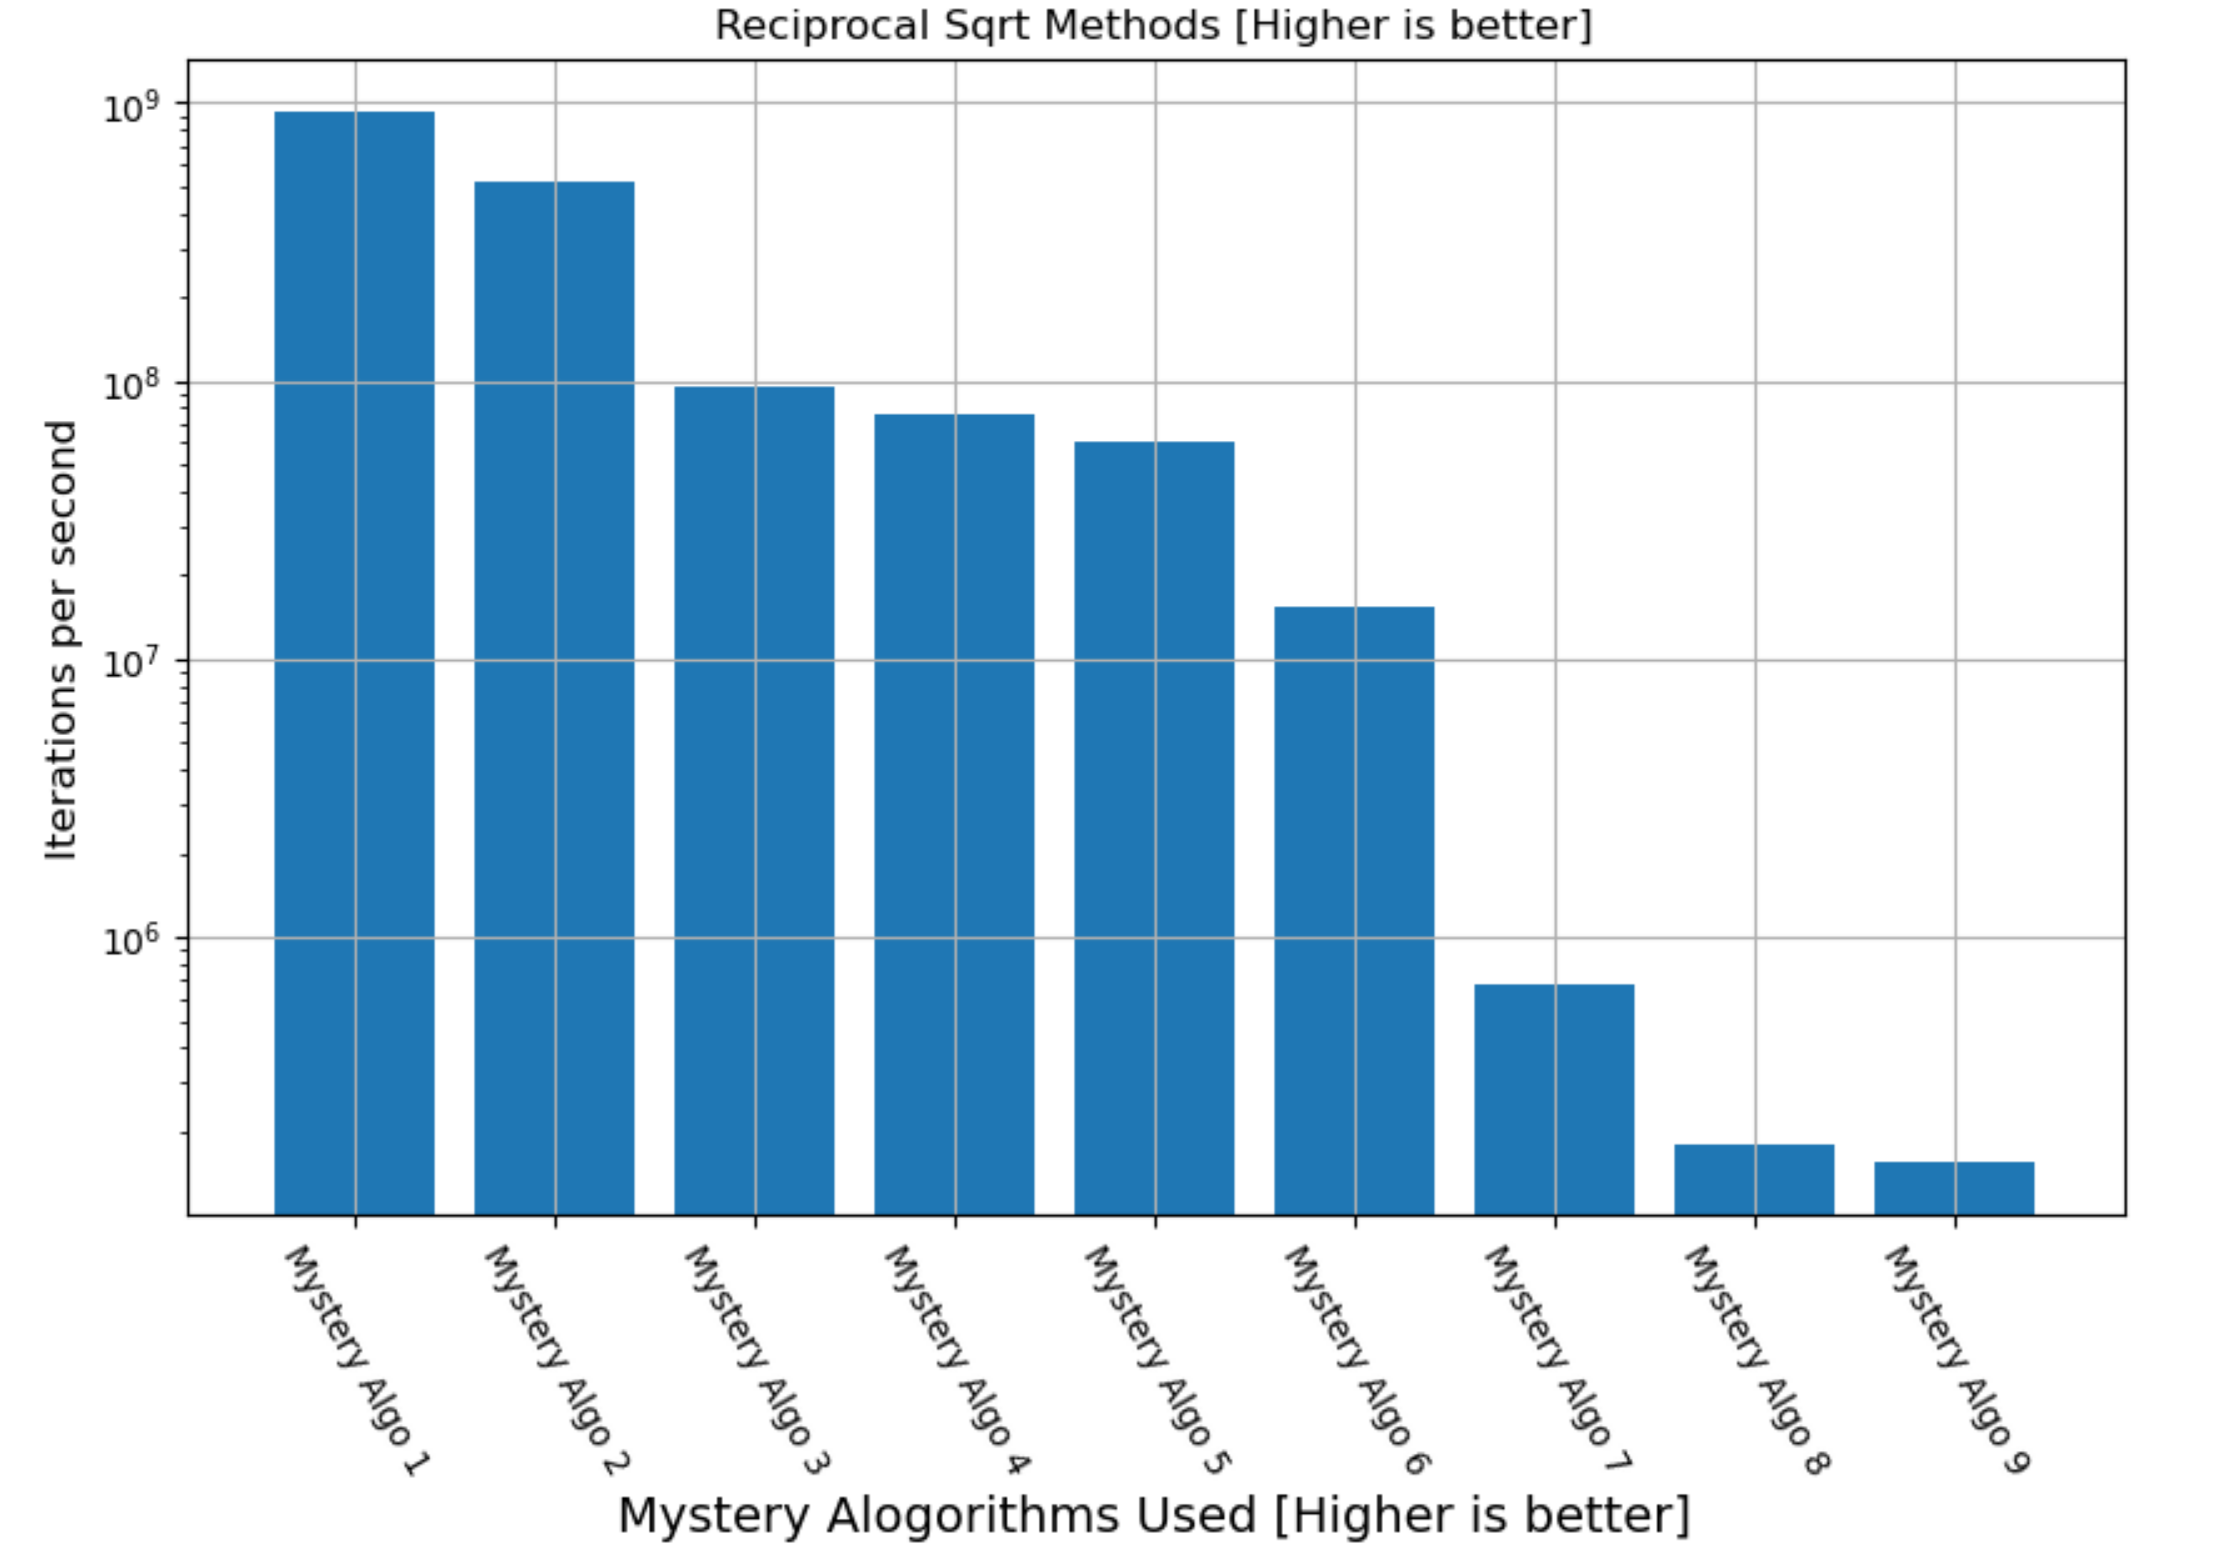

## Where is it used?
- ### Physics/ Engineering
    - ### Special Relativity Lorentz transformation
    - ## ${\displaystyle \gamma ={\frac {1}{\sqrt {1-{\frac {v^{2}}{c^{2}}}}}}}$
- ### 3D Graphics or ML applications needing normailization in space
    - #### vector normalization in video games and is mostly used in calculations involved in 3D programming
 
This is an intersting topic as the recent history of this computation shows a seesaw improvement in methods used

- Still find articles extolling virtue of Fast Reciprocal Sqrt as was implemeted in Quake III - Just an ingenious applicatiopn of Newton method to get fast approximations of this value
- Then the introduction by Intel of SSE instructions which compute reciprocal sqrt as part of SSE instruction set
- Where does it stand today?
- See article [Is Fast Inverse Square Root still Fast?](https://www.linkedin.com/pulse/fast-inverse-square-root-still-armin-kassemi-langroodi/?utm_source=share&utm_medium=member_android&utm_campaign=share_via)
- See article by ajcr
    - https://ajcr.net/fast-inverse-square-root-python/




## What we we test in this notebook?

In this workbook we will test the folloing approaches:

- PyTorch rsqrt:
    - Use torch built in function rsqrt()
- NP_Compose RecipSqrt
    - Use NumPy np.reicprocal(np.sqrt())
- NP_Simple a**-.5
    - Use Numpy implicit vectors: b = a**-.5
- Cython_Simple a**-.5
    - Use Cython variant of Simple a**-.5
- Numba_SImple a**-.5
    - Use Numba njit varaint of Simple a**-.5
- BruteForceLoopExact
    - Brute force loop approach no vectorization at all
- FRSNewtonLoop
    - Fast Reciprocal Sqrt using Newton Raphson and Quake III approach
- FRSNewtonVectorize
    - Fast Reciprocal Sqrt using Newton Raphson and Quake III approach vecortized with np.apply
- CythonFRSNewtonApply
    - Fast Reciprocal Sqrt using Newton Raphson and Quake III approach in Cython

In [ ]:
# Text color values
rd = '\033[91m'
gr = '\033[92m'
yl = '\033[93m'
bl = '\033[94m'
pk = '\033[95m'
tl = '\033[96m'
gy = '\033[97m'
bk = '\033[0m'

import time
import math
N =  1_000_000
a = [i for i in range(1, N)]
b = []
timing = {}

In [ ]:
t1 = time.time()
b = [1.0/math.sqrt(x) for x in a]
t2 = time.time()
timing[f'BruteForceLoopExact'] = N/(t2-t1)
print(f"elapsed {rd}{N/(t2-t1):,.1f} iter/sec{bk}")
b[:5]  # aproximate answer

# Apply imprecise Newton Fast approx

Adapted from wikipedia article about fast inverse square root

- [Wikipedia:_Fast_inverse_square_root](https://en.wikipedia.org/wiki/Fast_inverse_square_root)

And excellent blog write up by ajcr
- [acjr.net:The_Fast_Inverse_Square_Root_method_in_Python](https://ajcr.net/fast-inverse-square-root-python/)
- This article, after comparing several mehtods for computing reciprocal sqrt on **single value** recommends just using:
```python
a**-.5
```

Lets try vectorizing this function which **appoximates reciprocal sqrt using newton method**

In [ ]:
from ctypes import c_float, c_int32, cast, byref, POINTER
import time

def ctypes_isqrt(number):  # operates on single value at a time
    threehalfs = 1.5
    x2 = number * 0.5
    y = c_float(number)

    i = cast(byref(y), POINTER(c_int32)).contents.value
    i = c_int32(0x5f3759df - (i >> 1))
    y = cast(byref(i), POINTER(c_float)).contents.value

    y = y * (1.5 - (x2 * y * y))
    return y

In [ ]:
try:
    b = ctypes_isqrt(a)
except:
    print("Can't handle list or ndarray - just single value")

In [ ]:
t1 = time.time()
b = []
for i in range(1,  N ):
    b.append(ctypes_isqrt(i))
t2 = time.time()
timing[f'FRSNewtonLoop'] = N/(t2-t1)
print(f"elapsed {rd}{N/(t2-t1):,.1f} iter/sec{bk}")
b[:5]  # aproximate answer

# Assume we will do NumPy coversion 

for rest of cells in notebook

In [ ]:
import time
import numpy as np

a = np.array([i for i in range(1,     N)])
a = np.expand_dims(a, axis = 0)  # make the array the right sahpe for use by apply

### NumPy apply (vectorize along axis)

In [ ]:
t1 = time.time()
b = np.apply_along_axis(ctypes_isqrt, 0, a)
t2 = time.time()
timing['FRSNewtonVectorize'] = N/(t2-t1)
print(f"elapsed {rd}{N/(t2-t1):,.1f} iter/sec{bk}")
b[:5]  # aproximate answer

# Cython Newton Approximation Method

https://cython.readthedocs.io/en/latest/src/tutorial/cython_tutorial.html

In [ ]:
import numpy as np
a = np.array([i for i in range(1, N)])
a = np.expand_dims(a, axis = 0)  # make the array the right sahpe for use by apply


### Time compute for single value

In [ ]:
from cython_NewtonRecipSqrt import ctypes_nbsqrt
t1 = time.time()
print("estimate 1/sqrt(16)", ctypes_nbsqrt(16) ) # FOr a single value
t2 = time.time()
print(f"elapsed single calc {(t2-t1):,.1f} sec")


In [ ]:
t1 = time.time()
b = np.apply_along_axis(ctypes_nbsqrt, 0, a)
t2 = time.time()
timing['CythonFRSNewtonApply'] = N/(t2-t1)
print(f"elapsed {rd}{N/(t2-t1):,.1f} iter/sec{bk}")
b[:5]  # aproximate answer

In [ ]:
# ctypes_isqrt(a)   #error

# Cython Simple  Method

- Edit & save:  **cython_Exact.pyx**
   
```python
def ctypes_Exsqrt(x):  # operates on single value at a time
    y = x**(-.5)
    return y
```

- edit & save **setup.py**
  ```python
    from distutils.core import setup
    from Cython.Build import cythonize
    setup(ext_modules = cythonize('cython_NewtonRecipSqrt.pyx'))
    setup(ext_modules = cythonize('cython_Exact.pyx'))
```

- python setup.py build_ext --inplace
- setup(ext_modules = cythonize('cython_Exact.pyx')) creates cython_Eact.so



- now we can import using in Jupyter:

```python
    from cython_Exact import ctypes_Exsqrt
```

In [ ]:
from cython_Exact import ctypes_Exsqrt

In [ ]:
t1 = time.time()
b = ctypes_Exsqrt(a)
t2 = time.time()
timing['CythonExact'] = N/(t2-t1)
print(f"elapsed {gr}{N/(t2-t1):,.1f} iter/sec{bk}")
b[:5]  # aproximate answer

# Numba Simple approach
https://numba.pydata.org/numba-doc/latest/user/jit.html

In [ ]:
import numba
import numpy as np
N = 100_000_000
a = np.array([i for i in range(1, N)])
#a = np.expand_dims(a, axis = 0)  # make the array the right sahpe for use by apply

@numba.njit
def ctypes_nbsqrt(number):  # operates on single value at a time
  return number ** -0.5

In [ ]:
t1 = time.time()
ctypes_nbsqrt(a)
t2 = time.time()
timing['ExactNumba'] = N/(t2-t1)
print(f"elapsed {gr}{N/(t2-t1):,.1f} iter/sec{bk}")
b[:5]  # aproximate answer

# Assume we have converted "a" to NumPy

In [ ]:
import numpy as np
a = np.array([i for i in range(1, N)])

### NumPy Compose reciprocal and sqrt

In [ ]:
t1 = time.time()
b = np.reciprocal(np.sqrt(a))
t2 = time.time()
timing['ExactNP_recipSqrt'] = N/(t2-t1)
print(f"elapsed {gr}{N/(t2-t1):,.1f} iter/sec{bk}")
b[:5]  # aproximate answer

## Numpy Simple minded a**-.5

In [ ]:
t1 = time.time()
b = a**-.5
t2 = time.time()
timing['ExactNP_a**-.5'] = N/(t2-t1)
print(f"elapsed {gr}{N/(t2-t1):,.1f} iter/sec{bk}")
b[:5]  # aproximate answer

# PyTorch rsqrt

In [ ]:
import torch
t1 = time.time()
b = torch.rsqrt(torch.tensor(a))
t2 = time.time()
timing['PyTorch.rsqrt'] = N/(t2-t1)
print(f"elapsed {gr}{N/(t2-t1):,.1f} iter/sec{bk}")
b[:5]  # aproximate answer

In [ ]:
t1 = time.time()
b = a**-.5
t2 = time.time()
timing['ExactNP_a**-.5'] = N/(t2-t1)
print(f"elapsed {gr}{N/(t2-t1):,.1f} iter/sec{bk}")
b[:5]  # aproximate answer

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.title("Reciprocal Sqrt Methods [Higher is better]")
plt.ylabel("Iterations per second",fontsize=12)
plt.xlabel("Mystery Alogorithms Used [Higher is better]",fontsize=14)
plt.grid(True)
plt.yscale('log')
plt.xticks(rotation=-60)
timingH = dict(sorted(timing.items(), key=lambda x:x[1], reverse=True))
plt.bar(x = range(len(timingH)), height=timingH.values(), align='center', tick_label=list(timingH.keys()))
mysteryList = [f'Mystery Algo {i+1}' for i in range(len(timingH))]
#plt.bar(x = range(len(timingH)), height=timingH.values(), align='center', tick_label=mysteryList)
short = min(list(timingH.values()))
long = max(list(timingH.values()))
print('Speedup : {:4.0f} X'.format(long/short))

# Incomplete Experiments

### Use Intel compiler to make shared onject (so)


- Download from here: https://www.intel.com/content/www/us/en/developer/articles/tool/oneapi-standalone-components.html#dpcpp-cpp


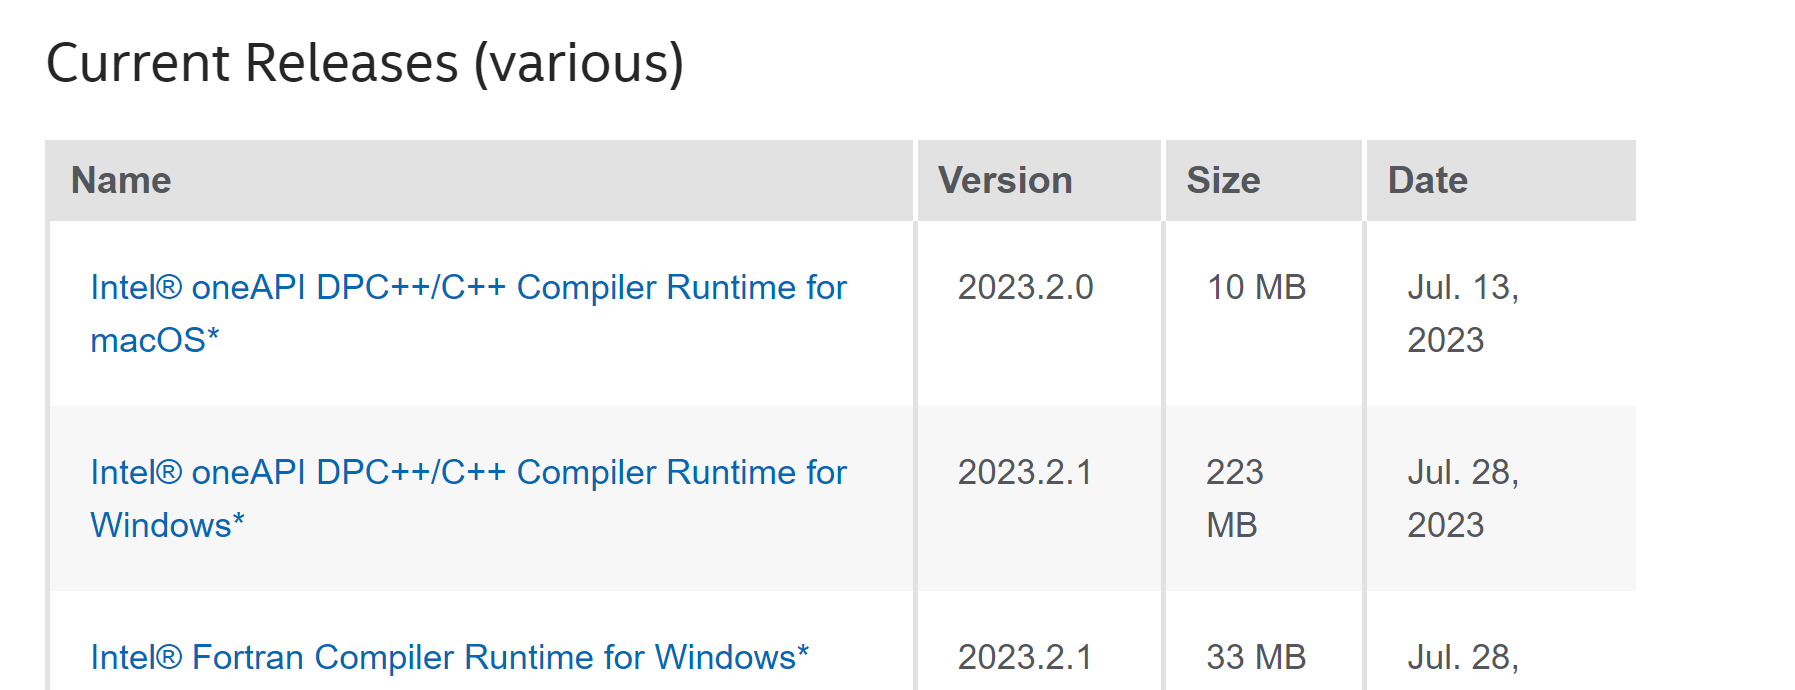


- Install on linux (WSL: Ubunutu)

```bash
sh Downloads/l_dpcpp-cpp-compiler_p_2023.2.1.8_offline.sh

source intel/oneapi/setvars.sh intel64 --force

cd Examples/python/

icx-cc -fPIC -shared -o bob_cython.so cython_Exact.c -I../../intel/oneapi/intelpython/python3.9/include/python3.9/

```

DID NOT GET THE COMPILER PART TO WORK YET
